# qstate metrics compare (MNIST01)

本 notebook 用 “量子态指标”视角比较：Real vs QDDPM baseline vs 指定 run (data/mnist01_run_*).

- 你可以在第 1 个代码单元里手动设置 `RUN_NAME` 为具体的 run 文件夹名（例： `mnist01_run_2025-12-30_153926`）。
- `RUN_NAME=None` 则只看 baseline 目录 `data/mnist01`。
- Real qstates 默认总从 baseline 加载（更稳定）。

In [22]:
import json
from pathlib import Path
from typing import Optional, Tuple

import numpy as np
import matplotlib.pyplot as plt

ROOT = Path('.').resolve()
BASE_DIR = ROOT / 'data' / 'mnist01'

# ====== 在这里手动指定 run 文件夹 ======
# 例：RUN_NAME = 'mnist01_run_2025-12-30_153926'
RUN_NAME: Optional[str] = 'mnist01_run_2025-12-30_153926'
# ======================================

RUN_DIR = (ROOT / 'data' / RUN_NAME) if RUN_NAME else None
if RUN_DIR is not None and not RUN_DIR.exists():
    raise FileNotFoundError(f'RUN_DIR not found: {RUN_DIR}')

n = 8
n_eval = 2000
seed = 42
rng = np.random.default_rng(seed)


def load_report(path: Path) -> Optional[dict]:
    if not path.exists():
        return None
    return json.loads(path.read_text(encoding='utf-8'))


def pick_report(gen_dir: Path) -> Optional[Path]:
    """兼容两种命名：
    - eval_report_qstate.json：只含量子态指标（旧格式/或某些脚本输出）
    - eval_report.json：全量报告（含 qstate_metrics / qstate_natural_distance 等，当前 run 使用这个）
    """
    p_q = gen_dir / 'eval_report_qstate.json'
    if p_q.exists():
        return p_q
    p = gen_dir / 'eval_report.json'
    if p.exists():
        return p
    return None


def load_states(path: Path, n: int, n_eval: int, rng: np.random.Generator) -> np.ndarray:
    if not path.exists():
        raise FileNotFoundError(str(path))
    q = np.load(path)
    if not np.iscomplexobj(q):
        q = q.astype(np.complex128)
    if q.ndim != 2 or q.shape[1] != 2**n:
        raise ValueError(f'{path} shape {q.shape} != (N,{2**n})')
    if q.shape[0] > n_eval:
        idx = rng.choice(q.shape[0], size=n_eval, replace=False)
        q = q[idx]
    q = q / np.linalg.norm(q, axis=1, keepdims=True)
    return q


def basis_signs_z(n: int) -> np.ndarray:
    basis = np.arange(2**n, dtype=np.int64)
    signs = np.empty((2**n, n), dtype=np.float64)
    for i in range(n):
        bit = (basis >> (n - 1 - i)) & 1
        signs[:, i] = 1.0 - 2.0 * bit
    return signs


def basis_signs_zz(n: int) -> np.ndarray:
    z = basis_signs_z(n)
    cols = []
    for i in range(n):
        for j in range(i + 1, n):
            cols.append((z[:, i] * z[:, j])[:, None])
    return np.concatenate(cols, axis=1) if cols else np.empty((2**n, 0), dtype=np.float64)


SIGNS_Z = basis_signs_z(n)
SIGNS_ZZ = basis_signs_zz(n)
PAIR_IJ = [(i, j) for i in range(n) for j in range(i + 1, n)]


def z_and_zz_features(q: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    p = (np.abs(q) ** 2).astype(np.float64)
    z = p @ SIGNS_Z
    zz = p @ SIGNS_ZZ
    return z.astype(np.float32), zz.astype(np.float32)


def per_qubit_purity(q: np.ndarray, n: int, maxN: int = 512) -> np.ndarray:
    q = q[: min(maxN, q.shape[0])]
    q = q / np.linalg.norm(q, axis=1, keepdims=True)
    N = q.shape[0]
    psi_t = q.reshape((N,) + (2,) * n)
    pur = np.zeros((N, n), dtype=np.float64)
    for i in range(n):
        axes = (0, 1 + i) + tuple(j for j in range(1, n + 1) if j != 1 + i)
        t = np.transpose(psi_t, axes).reshape(N, 2, -1)
        rho = t @ np.conjugate(t).transpose(0, 2, 1)
        pur[:, i] = np.real(np.einsum('nij,njk->nik', rho, rho).trace(axis1=1, axis2=2))
    return pur


# ===== paths =====
PATH_REAL = BASE_DIR / 'qstates_test_n8.npy'

PATH_QDDPM_BASE = BASE_DIR / 'gen' / 'qddpm' / 'qstates_gen_n8.npy'
PATH_QDT_BASE = BASE_DIR / 'gen' / 'qdt' / 'qstates_gen_n8.npy'
REP_QDDPM_BASE = pick_report(BASE_DIR / 'gen' / 'qddpm')
REP_QDT_BASE = pick_report(BASE_DIR / 'gen' / 'qdt')

PATH_QDDPM_RUN = (RUN_DIR / 'gen' / 'qddpm' / 'qstates_gen_n8.npy') if RUN_DIR else None
PATH_QDT_RUN = (RUN_DIR / 'gen' / 'qdt' / 'qstates_gen_n8.npy') if RUN_DIR else None
REP_QDDPM_RUN = pick_report(RUN_DIR / 'gen' / 'qddpm') if RUN_DIR else None
REP_QDT_RUN = pick_report(RUN_DIR / 'gen' / 'qdt') if RUN_DIR else None


# ===== load qstates =====
q_real = load_states(PATH_REAL, n=n, n_eval=n_eval, rng=rng)
q_qddpm_base = load_states(PATH_QDDPM_BASE, n=n, n_eval=n_eval, rng=rng) if PATH_QDDPM_BASE.exists() else None
q_qdt_base = load_states(PATH_QDT_BASE, n=n, n_eval=n_eval, rng=rng) if PATH_QDT_BASE.exists() else None

q_qddpm_run = load_states(PATH_QDDPM_RUN, n=n, n_eval=n_eval, rng=rng) if (PATH_QDDPM_RUN and PATH_QDDPM_RUN.exists()) else None
q_qdt_run = load_states(PATH_QDT_RUN, n=n, n_eval=n_eval, rng=rng) if (PATH_QDT_RUN and PATH_QDT_RUN.exists()) else None


# ===== features =====
z_real, zz_real = z_and_zz_features(q_real)
pur_real = per_qubit_purity(q_real, n=n, maxN=512)
th_real = np.arccos(np.clip(z_real, -1.0, 1.0))


def _maybe_feats(q):
    if q is None:
        return None, None, None, None
    z, zz = z_and_zz_features(q)
    pur = per_qubit_purity(q, n=n, maxN=512)
    th = np.arccos(np.clip(z, -1.0, 1.0))
    return z, zz, pur, th


z_qddpm_base, zz_qddpm_base, pur_qddpm_base, th_qddpm_base = _maybe_feats(q_qddpm_base)
z_qdt_base, zz_qdt_base, pur_qdt_base, th_qdt_base = _maybe_feats(q_qdt_base)
z_qddpm_run, zz_qddpm_run, pur_qddpm_run, th_qddpm_run = _maybe_feats(q_qddpm_run)
z_qdt_run, zz_qdt_run, pur_qdt_run, th_qdt_run = _maybe_feats(q_qdt_run)


print('Loaded:')
print('  BASE_DIR =', BASE_DIR)
print('  RUN_DIR  =', RUN_DIR)
print('  real     =', q_real.shape)
print('  qddpm_base exists:', z_qddpm_base is not None)
print('  qddpm_run  exists:', z_qddpm_run is not None)

print('\nQuick purity (mean over samples & qubits):')
print('  real       :', float(pur_real.mean()))
if pur_qddpm_base is not None: print('  qddpm_base :', float(pur_qddpm_base.mean()))
if pur_qddpm_run is not None:  print('  qddpm_run  :', float(pur_qddpm_run.mean()))
if pur_qdt_base is not None:   print('  qdt_base   :', float(pur_qdt_base.mean()))
if pur_qdt_run is not None:    print('  qdt_run    :', float(pur_qdt_run.mean()))


def show_report(tag: str, rp: Optional[Path]):
    if rp is None:
        print(f'\n{tag}: report missing -> (no file)')
        return
    r = load_report(rp)
    if r is None:
        print(f'\n{tag}: report missing -> {rp}')
        return

    qm = r.get('qstate_metrics', {})
    # 兼容：全量 report 同时也有 qstate_natural_distance
    nat = qm.get('natural_distance', r.get('qstate_natural_distance'))

    print(f'\n{tag}: {rp.name} ({rp})')
    print('  natural_distance =', nat)
    print('  feature_mmd_rbf_z_zz =', qm.get('feature_mmd_rbf_z_zz'))
    print('  single_qubit_purity_mean =', qm.get('single_qubit_purity_mean'))


show_report('QDDPM baseline', REP_QDDPM_BASE)
show_report('QDT baseline', REP_QDT_BASE)
show_report('QDDPM run', REP_QDDPM_RUN)
show_report('QDT run', REP_QDT_RUN)


Loaded:
  BASE_DIR = /home/licunchun/QuantGenMdlForUSTCCourse/data/mnist01
  RUN_DIR  = /home/licunchun/QuantGenMdlForUSTCCourse/data/mnist01_run_2025-12-30_153926
  real     = (2000, 256)
  qddpm_base exists: True
  qddpm_run  exists: True

Quick purity (mean over samples & qubits):
  real       : 1.0000000143772922
  qddpm_base : 0.5243195666262181
  qddpm_run  : 1.0000001532607712
  qdt_base   : 0.5058954884589184
  qdt_run    : 1.0000001349835657

QDDPM baseline: eval_report_qstate.json (/home/licunchun/QuantGenMdlForUSTCCourse/data/mnist01/gen/qddpm/eval_report_qstate.json)
  natural_distance = 0.060807764530181885
  feature_mmd_rbf_z_zz = 0.15542832351689007
  single_qubit_purity_mean = 0.5243195809453027

QDT baseline: eval_report_qstate.json (/home/licunchun/QuantGenMdlForUSTCCourse/data/mnist01/gen/qdt/eval_report_qstate.json)
  natural_distance = 0.06112104654312134
  feature_mmd_rbf_z_zz = 0.16473906955065987
  single_qubit_purity_mean = 0.5058955132262781

QDDPM run: eval_r

In [32]:
# ===== Optional: include QGAN in the same comparisons (if files exist) =====
# Baseline QGAN expected at: data/mnist01/gen/qgan/qstates_gen_n8.npy
# Run QGAN expected at:      data/mnist01_run_*/gen/qgan/qstates_gen_n8.npy

PATH_QGAN_BASE = BASE_DIR / 'gen' / 'qgan' / 'qstates_gen_n8.npy'
REP_QGAN_BASE = pick_report(BASE_DIR / 'gen' / 'qgan')

PATH_QGAN_RUN = (RUN_DIR / 'gen' / 'qgan' / 'qstates_gen_n8.npy') if RUN_DIR else None
REP_QGAN_RUN = pick_report(RUN_DIR / 'gen' / 'qgan') if RUN_DIR else None

q_qgan_base = load_states(PATH_QGAN_BASE, n=n, n_eval=n_eval, rng=rng) if PATH_QGAN_BASE.exists() else None
q_qgan_run = load_states(PATH_QGAN_RUN, n=n, n_eval=n_eval, rng=rng) if (PATH_QGAN_RUN and PATH_QGAN_RUN.exists()) else None

z_qgan_base, zz_qgan_base, pur_qgan_base, th_qgan_base = _maybe_feats(q_qgan_base)
z_qgan_run, zz_qgan_run, pur_qgan_run, th_qgan_run = _maybe_feats(q_qgan_run)

print('\nQGAN availability:')
print('  qgan_base exists:', z_qgan_base is not None)
print('  qgan_run  exists:', z_qgan_run is not None)

show_report('QGAN baseline', REP_QGAN_BASE)
show_report('QGAN run', REP_QGAN_RUN)



QGAN availability:
  qgan_base exists: False
  qgan_run  exists: False

QGAN baseline: report missing -> (no file)

QGAN run: report missing -> (no file)


Found reports:
  - QDDPM (run): /home/licunchun/QuantGenMdlForUSTCCourse/data/mnist01_run_2025-12-30_153926/gen/qddpm/eval_report.json
  - QDT (run): /home/licunchun/QuantGenMdlForUSTCCourse/data/mnist01_run_2025-12-30_153926/gen/qdt/eval_report.json
  - QDDPM (baseline): /home/licunchun/QuantGenMdlForUSTCCourse/data/mnist01/gen/qddpm/eval_report_qstate.json
  - QDT (baseline): /home/licunchun/QuantGenMdlForUSTCCourse/data/mnist01/gen/qdt/eval_report_qstate.json

RUN takeaway:
  - Best (lowest) natural distance: QDDPM (run) = 0.4502
  - Best (lowest) Z/ZZ MMD:         QDDPM (run) = 0.1346
  - Best (highest) purity mean:     QDDPM (run) = 1.0000


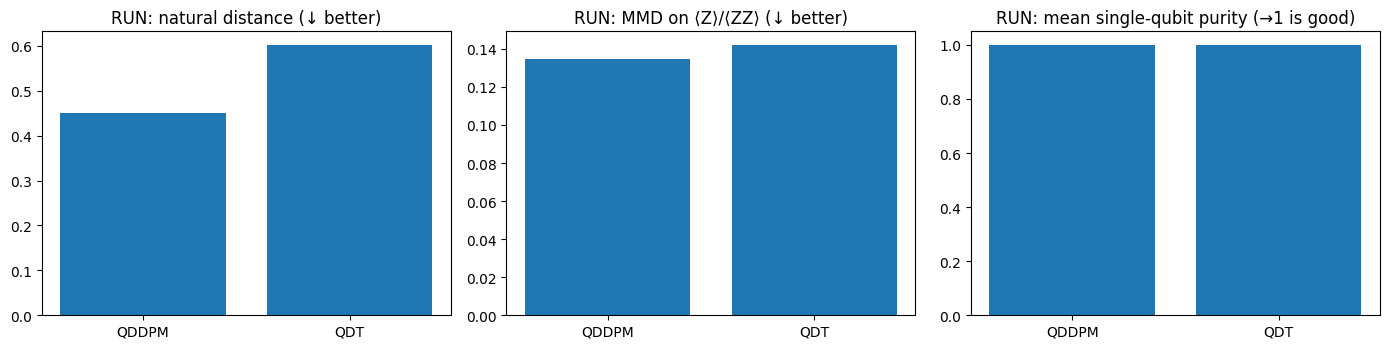

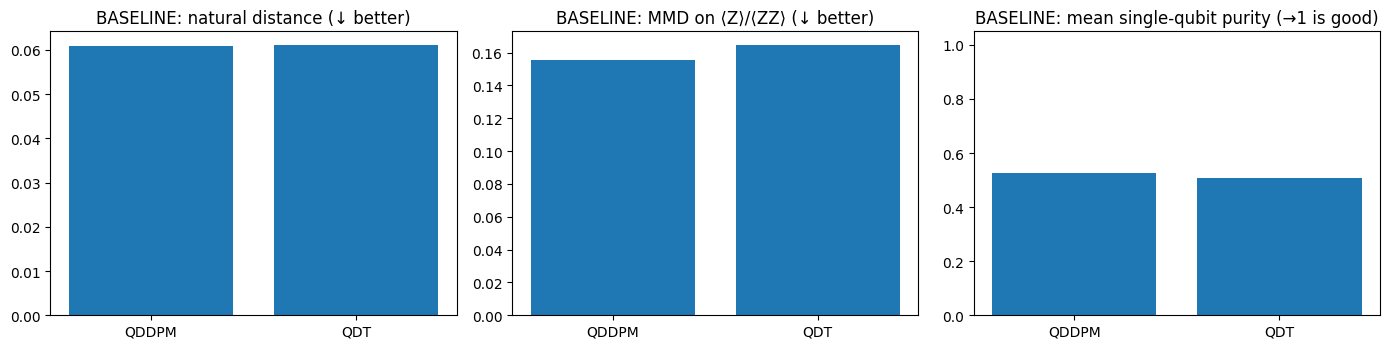

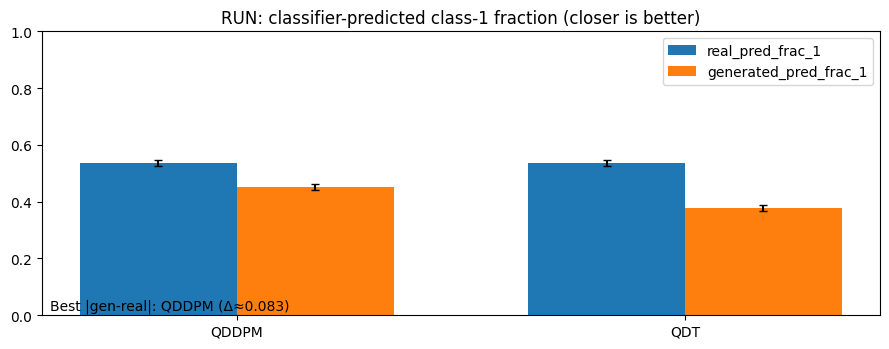

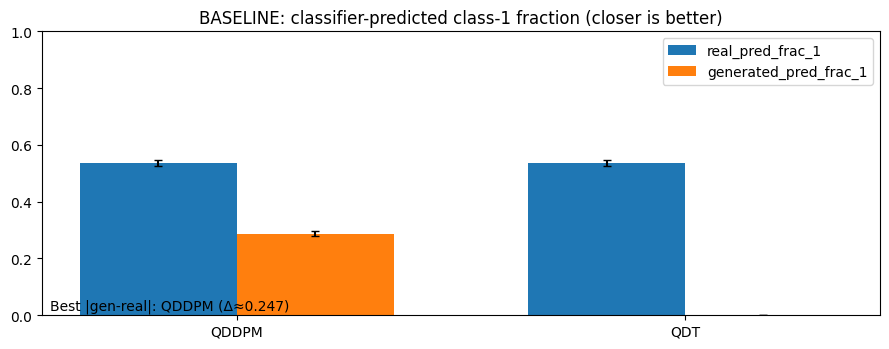

In [31]:
# === Report summary plots (for course presentation) ===
# This cell summarizes key metrics from eval_report*.json across models.

from __future__ import annotations

from pathlib import Path
import json
import math
import numpy as np
import matplotlib.pyplot as plt


def _safe_load_json(path: Path | None):
    if path is None:
        return None
    try:
        with open(path, "r") as f:
            return json.load(f)
    except FileNotFoundError:
        return None


def _auto_pick_report(gen_dir: Path) -> Path | None:
    # Prefer qstate-focused report if present, else fall back.
    for name in ["eval_report_qstate.json", "eval_report.json"]:
        p = gen_dir / name
        if p.exists():
            return p
    return None


def _get_qstate_metrics(report: dict | None) -> dict:
    if not isinstance(report, dict):
        return {}
    qm = report.get("qstate_metrics")
    if isinstance(qm, dict):
        out = dict(qm)
    else:
        out = {}

    # Backward/alternate key
    if "natural_distance" not in out and "qstate_natural_distance" in report:
        out["natural_distance"] = report.get("qstate_natural_distance")

    return out


def _extract_metrics(report: dict | None) -> dict:
    qm = _get_qstate_metrics(report)
    return {
        # quantum-state primary
        "q_natural": qm.get("natural_distance"),
        "q_mmd_z_zz": qm.get("feature_mmd_rbf_z_zz"),
        "purity": qm.get("single_qubit_purity_mean"),
        # auxiliary image/classifier metrics
        "kid_feat": report.get("kid_feat") if isinstance(report, dict) else None,
        "latent_mmd_rbf": report.get("latent_mmd_rbf") if isinstance(report, dict) else None,
        "real_pred_frac_1": report.get("real_pred_frac_1") if isinstance(report, dict) else None,
        "generated_pred_frac_1": report.get("generated_pred_frac_1") if isinstance(report, dict) else None,
        "generated_conf_mean": report.get("generated_conf_mean") if isinstance(report, dict) else None,
        "generated_conf_std": report.get("generated_conf_std") if isinstance(report, dict) else None,
        "n_real": report.get("n_real") if isinstance(report, dict) else None,
        "n_gen": report.get("n_gen") if isinstance(report, dict) else None,
    }


def _binom_se(p: float | None, n: int | None) -> float | None:
    if p is None or n is None or n <= 0:
        return None
    p = float(p)
    return math.sqrt(max(p * (1 - p), 0.0) / n)


def _collect_reports() -> dict:
    # Uses variables from the loading cell if present.
    out = {}

    # --- Run dirs (expected) ---
    run_candidates = []
    if "RUN_DIR" in globals():
        run_dir: Path = RUN_DIR
        run_candidates += [
            ("QDDPM (run)", _auto_pick_report(run_dir / "gen/qddpm")),
            ("QDT (run)", _auto_pick_report(run_dir / "gen/qdt")),
            ("QGAN (run)", _auto_pick_report(run_dir / "gen/qgan")),
        ]

    # --- Baseline dirs (optional) ---
    base_candidates = []
    if "BASE_DIR" in globals():
        base_dir: Path = BASE_DIR
        base_candidates += [
            ("QDDPM (baseline)", _auto_pick_report(base_dir / "gen/qddpm")),
            ("QDT (baseline)", _auto_pick_report(base_dir / "gen/qdt")),
            ("QGAN (baseline)", _auto_pick_report(base_dir / "gen/qgan")),
        ]

    # Allow already-computed REP_* paths (if exist)
    for k, label in [
        ("REP_QDDPM_RUN", "QDDPM (run)"),
        ("REP_QDT_RUN", "QDT (run)"),
        ("REP_QDDPM_BASE", "QDDPM (baseline)"),
        ("REP_QDT_BASE", "QDT (baseline)"),
    ]:
        if k in globals() and globals()[k] is not None:
            # Overwrite auto-picked path if provided explicitly by upstream cell
            out[label] = globals()[k]

    # Fill missing from auto-picked
    for label, p in run_candidates + base_candidates:
        if label not in out and p is not None:
            out[label] = p

    # Drop missing
    out = {label: p for label, p in out.items() if p is not None and Path(p).exists()}
    return out


reports = _collect_reports()
print("Found reports:")
for k, v in reports.items():
    print(f"  - {k}: {v}")

rows = []
for label, path in reports.items():
    r = _safe_load_json(Path(path))
    m = _extract_metrics(r)
    m["label"] = label
    rows.append(m)

if not rows:
    raise RuntimeError("No eval_report*.json found. Check RUN_NAME / directory structure.")

# Split run vs baseline for clearer presentation
run_rows = [x for x in rows if "(run)" in x["label"]]
base_rows = [x for x in rows if "(baseline)" in x["label"]]


def _plot_quantum_bars(axs, subset, title_prefix: str):
    labels = [x["label"].replace(" (run)", "").replace(" (baseline)", "") for x in subset]
    x = np.arange(len(labels))

    # 1) natural distance (lower is better)
    vals = [x_.get("q_natural") for x_ in subset]
    axs[0].bar(x, vals)
    axs[0].set_title(f"{title_prefix}: natural distance (↓ better)")
    axs[0].set_xticks(x, labels, rotation=0)

    # 2) feature MMD on Z/ZZ moments (lower is better)
    vals = [x_.get("q_mmd_z_zz") for x_ in subset]
    axs[1].bar(x, vals)
    axs[1].set_title(f"{title_prefix}: MMD on ⟨Z⟩/⟨ZZ⟩ (↓ better)")
    axs[1].set_xticks(x, labels, rotation=0)

    # 3) single-qubit purity mean (≈1 means product-like; ≈0.5 indicates strong entanglement/mismatch)
    vals = [x_.get("purity") for x_ in subset]
    axs[2].bar(x, vals)
    axs[2].set_ylim(0.0, 1.05)
    axs[2].set_title(f"{title_prefix}: mean single-qubit purity (→1 is good)")
    axs[2].set_xticks(x, labels, rotation=0)


# --- Quantum primary metrics figures ---
if run_rows:
    fig, axs = plt.subplots(1, 3, figsize=(14, 3.6))
    _plot_quantum_bars(axs, run_rows, "RUN")
    fig.tight_layout()

if base_rows:
    fig, axs = plt.subplots(1, 3, figsize=(14, 3.6))
    _plot_quantum_bars(axs, base_rows, "BASELINE")
    fig.tight_layout()


# --- Classifier-based prior alignment (auxiliary) ---
# We visualize: real_pred_frac_1 vs generated_pred_frac_1 with binomial SE bars.
# This is meaningful only when qstates->image decoding is valid (here, purity≈1 suggests product manifold is aligned).

def _plot_pred_frac(subset, title_prefix: str):
    labels = [x["label"].replace(" (run)", "").replace(" (baseline)", "") for x in subset]
    x = np.arange(len(labels))

    real = [x_.get("real_pred_frac_1") for x_ in subset]
    gen = [x_.get("generated_pred_frac_1") for x_ in subset]
    n_real = [x_.get("n_real") for x_ in subset]
    n_gen = [x_.get("n_gen") for x_ in subset]

    real_se = [(_binom_se(p, n) or 0.0) for p, n in zip(real, n_real)]
    gen_se = [(_binom_se(p, n) or 0.0) for p, n in zip(gen, n_gen)]

    w = 0.35
    fig, ax = plt.subplots(1, 1, figsize=(9, 3.6))
    ax.bar(x - w / 2, real, width=w, yerr=real_se, capsize=3, label="real_pred_frac_1")
    ax.bar(x + w / 2, gen, width=w, yerr=gen_se, capsize=3, label="generated_pred_frac_1")
    ax.set_title(f"{title_prefix}: classifier-predicted class-1 fraction (closer is better)")
    ax.set_xticks(x, labels)
    ax.set_ylim(0.0, 1.0)
    ax.legend()

    # Also show absolute mismatch as text
    diffs = []
    for r, g in zip(real, gen):
        if r is None or g is None:
            diffs.append(None)
        else:
            diffs.append(abs(float(g) - float(r)))
    best = None
    if any(d is not None for d in diffs):
        best = min((d, lab) for d, lab in zip(diffs, labels) if d is not None)
    if best is not None:
        d, lab = best
        ax.text(0.01, 0.02, f"Best |gen-real|: {lab} (Δ≈{d:.3f})", transform=ax.transAxes)

    fig.tight_layout()


if run_rows:
    _plot_pred_frac(run_rows, "RUN")
if base_rows:
    _plot_pred_frac(base_rows, "BASELINE")


# --- Quick textual takeaway (for your slide) ---
# Prefer quantum metrics for the main claim.

def _best_label(subset, key: str, mode: str = "min"):
    pairs = [(x["label"], x.get(key)) for x in subset]
    pairs = [(lab, v) for lab, v in pairs if v is not None]
    if not pairs:
        return None
    if mode == "min":
        return min(pairs, key=lambda t: t[1])
    return max(pairs, key=lambda t: t[1])

if run_rows:
    best_nat = _best_label(run_rows, "q_natural", "min")
    best_mmd = _best_label(run_rows, "q_mmd_z_zz", "min")
    best_pur = _best_label(run_rows, "purity", "max")
    print("\nRUN takeaway:")
    if best_nat:
        print(f"  - Best (lowest) natural distance: {best_nat[0]} = {best_nat[1]:.4f}")
    if best_mmd:
        print(f"  - Best (lowest) Z/ZZ MMD:         {best_mmd[0]} = {best_mmd[1]:.4f}")
    if best_pur:
        print(f"  - Best (highest) purity mean:     {best_pur[0]} = {best_pur[1]:.4f}")


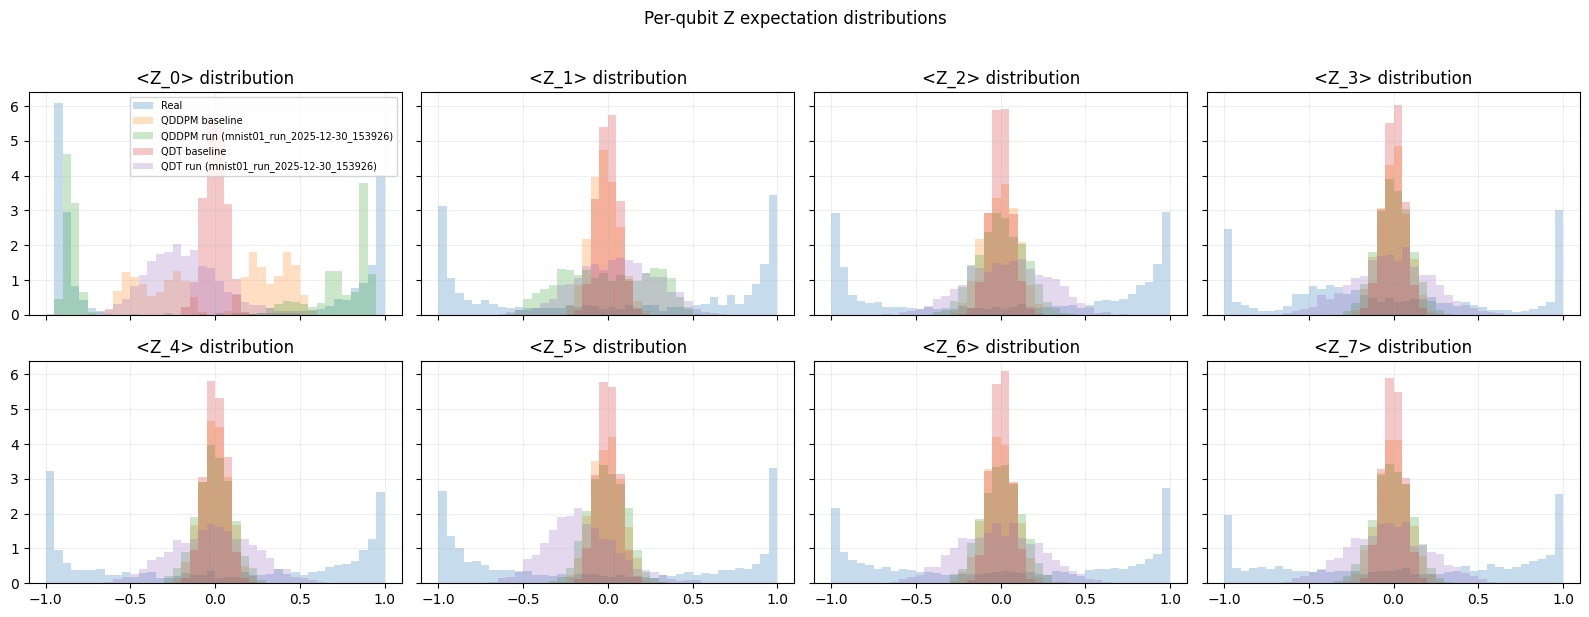

In [28]:
# 1) 每个 qubit 的 <Z_i> 分布对比（Real vs QDDPM vs QDT vs QGAN；baseline + run）

def _series_for_plot():
    series = [("Real", z_real)]

    if z_qddpm_base is not None:
        series.append(("QDDPM baseline", z_qddpm_base))
    if z_qddpm_run is not None:
        label = f"QDDPM run ({RUN_NAME})" if RUN_NAME else "QDDPM run"
        series.append((label, z_qddpm_run))

    if z_qdt_base is not None:
        series.append(("QDT baseline", z_qdt_base))
    if z_qdt_run is not None:
        label = f"QDT run ({RUN_NAME})" if RUN_NAME else "QDT run"
        series.append((label, z_qdt_run))

    # QGAN (optional)
    if "z_qgan_base" in globals() and z_qgan_base is not None:
        series.append(("QGAN baseline", z_qgan_base))
    if "z_qgan_run" in globals() and z_qgan_run is not None:
        label = f"QGAN run ({RUN_NAME})" if RUN_NAME else "QGAN run"
        series.append((label, z_qgan_run))

    return series

series = _series_for_plot()

fig, axes = plt.subplots(2, 4, figsize=(16, 6), sharex=True, sharey=True)
bins = np.linspace(-1, 1, 41)

for i, ax in enumerate(axes.flat):
    for name, z in series:
        ax.hist(z[:, i], bins=bins, density=True, alpha=0.22, label=name)
    ax.set_title(f"<Z_{i}> distribution")
    ax.grid(True, alpha=0.2)

axes.flat[0].legend(loc="upper right", fontsize=7)
fig.suptitle("Per-qubit Z expectation distributions", y=1.02)
plt.tight_layout()
plt.show()


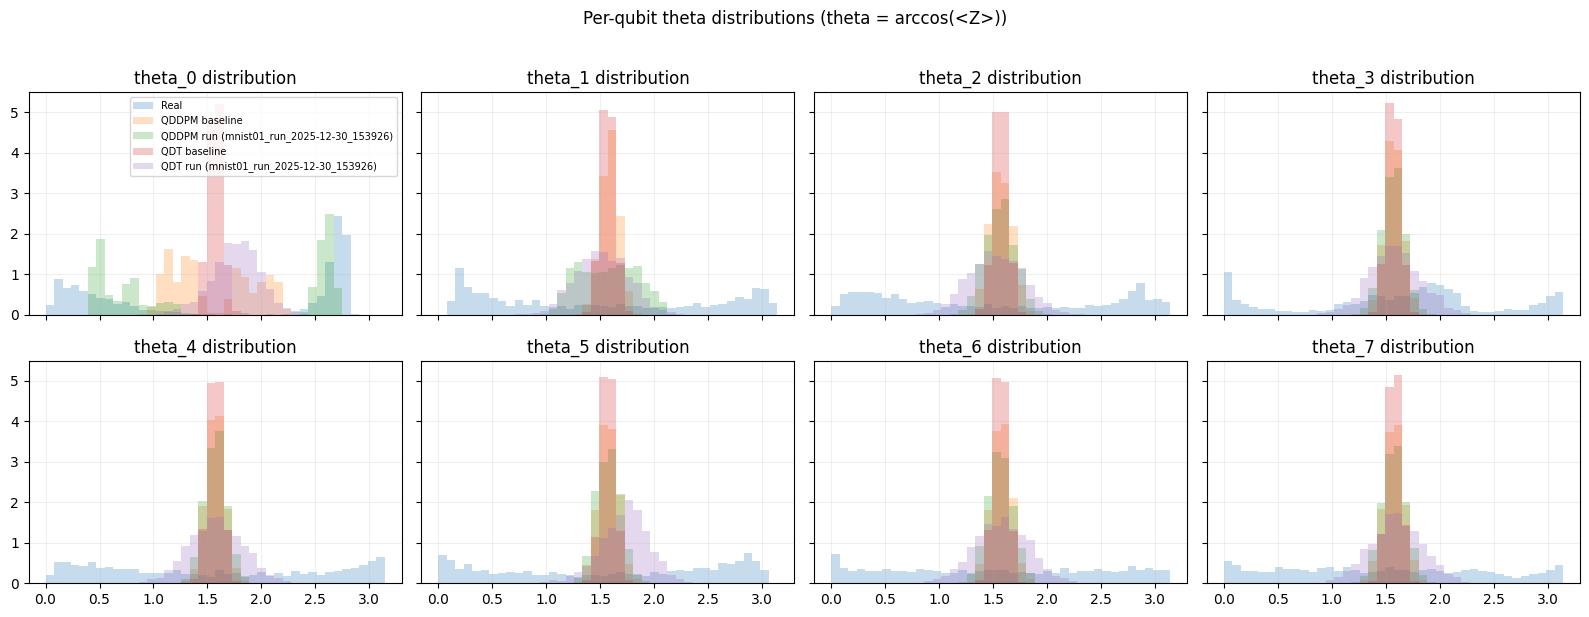

In [29]:
# 2) theta_i = arccos(<Z_i>) 分布对比（更贴近 product Ry 编码）

def _theta_series_for_plot():
    series = [("Real", th_real)]

    if th_qddpm_base is not None:
        series.append(("QDDPM baseline", th_qddpm_base))
    if th_qddpm_run is not None:
        label = f"QDDPM run ({RUN_NAME})" if RUN_NAME else "QDDPM run"
        series.append((label, th_qddpm_run))

    if th_qdt_base is not None:
        series.append(("QDT baseline", th_qdt_base))
    if th_qdt_run is not None:
        label = f"QDT run ({RUN_NAME})" if RUN_NAME else "QDT run"
        series.append((label, th_qdt_run))

    # QGAN (optional)
    if "th_qgan_base" in globals() and th_qgan_base is not None:
        series.append(("QGAN baseline", th_qgan_base))
    if "th_qgan_run" in globals() and th_qgan_run is not None:
        label = f"QGAN run ({RUN_NAME})" if RUN_NAME else "QGAN run"
        series.append((label, th_qgan_run))

    return series

series = _theta_series_for_plot()

fig, axes = plt.subplots(2, 4, figsize=(16, 6), sharex=True, sharey=True)
bins = np.linspace(0.0, float(np.pi), 41)

for i, ax in enumerate(axes.flat):
    for name, th in series:
        ax.hist(th[:, i], bins=bins, density=True, alpha=0.22, label=name)
    ax.set_title(f"theta_{i} distribution")
    ax.grid(True, alpha=0.2)

axes.flat[0].legend(loc="upper right", fontsize=7)
fig.suptitle("Per-qubit theta distributions (theta = arccos(<Z>))", y=1.02)
plt.tight_layout()
plt.show()


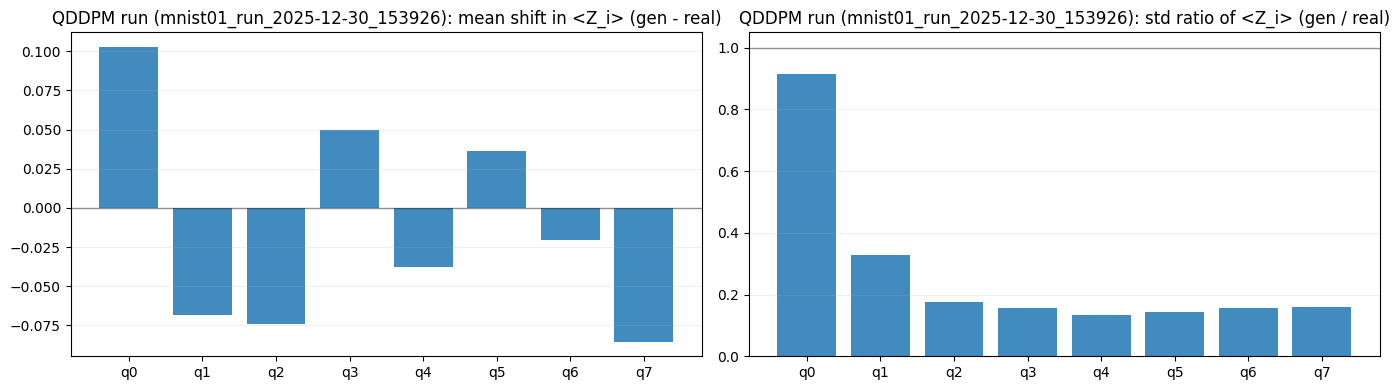

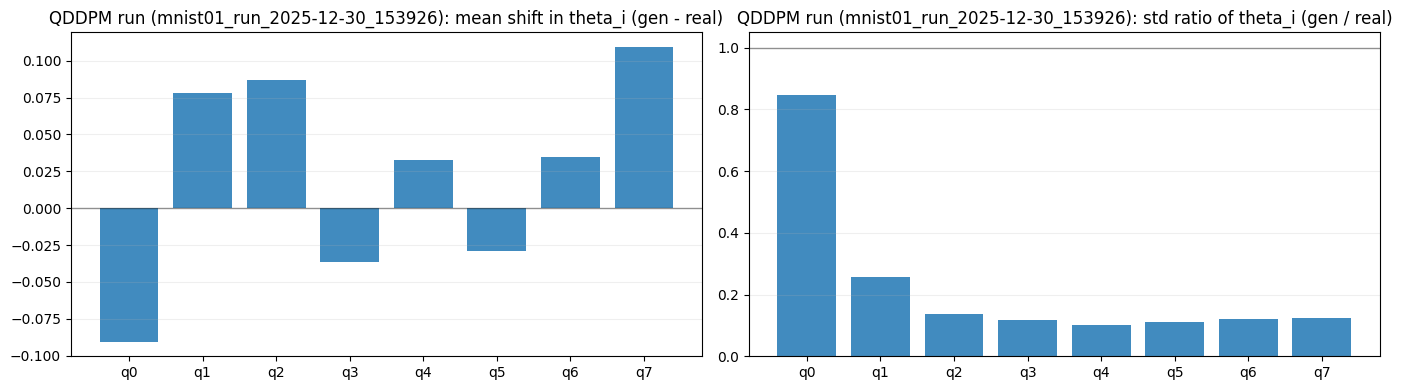

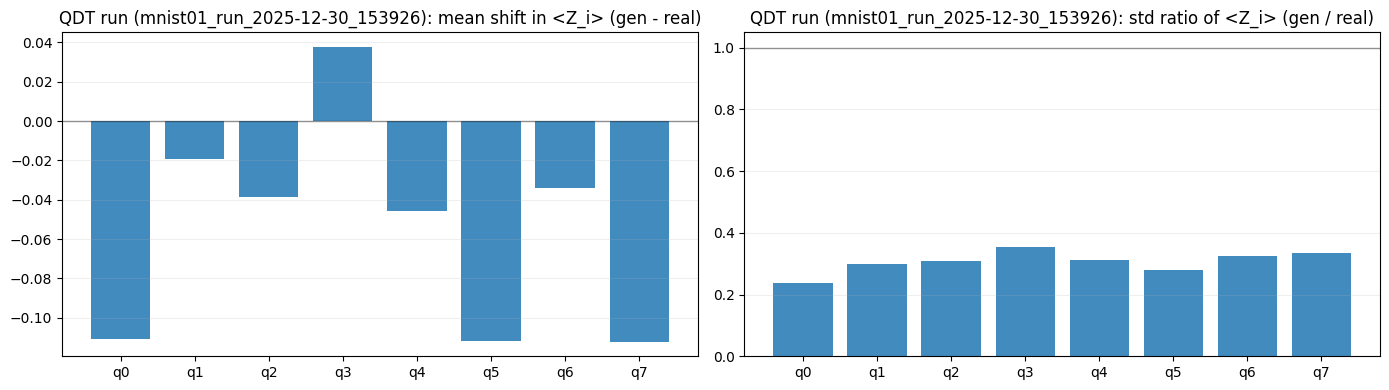

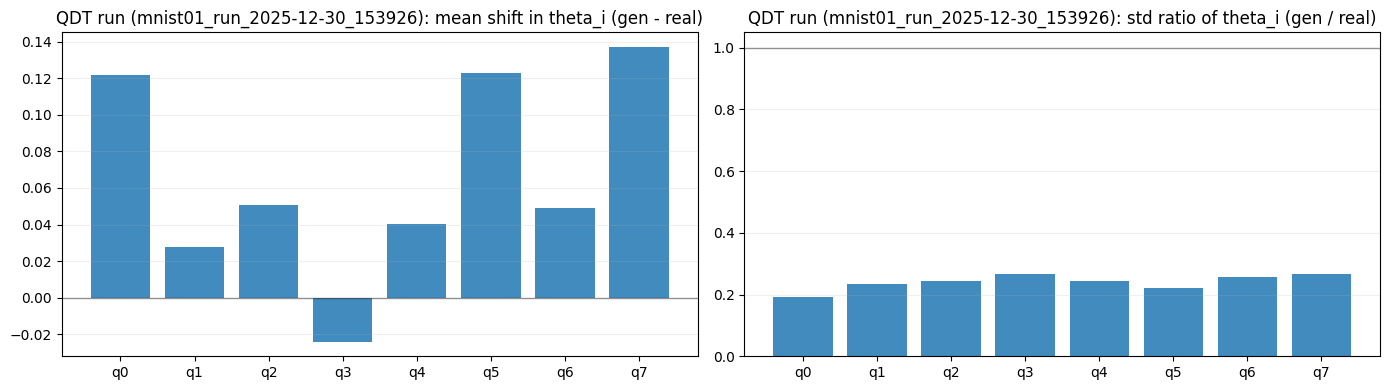

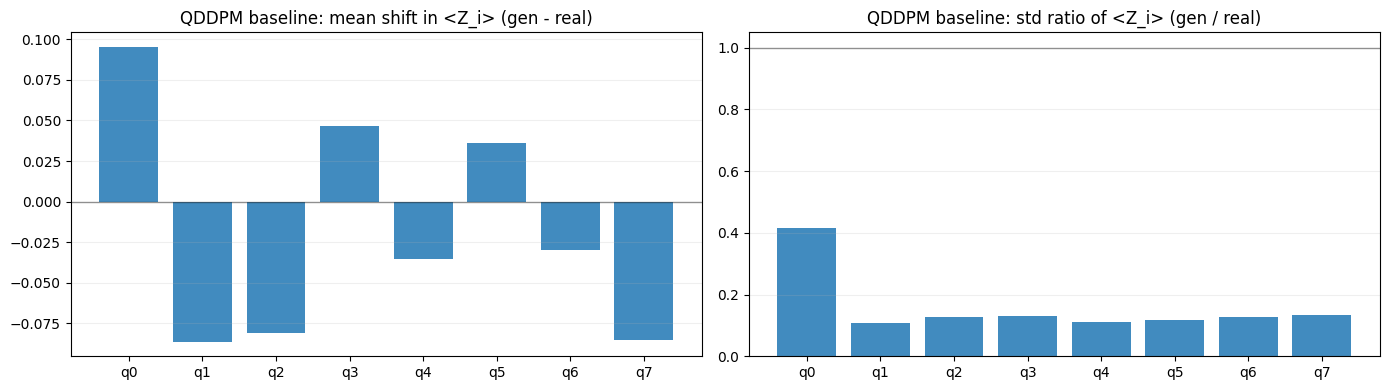

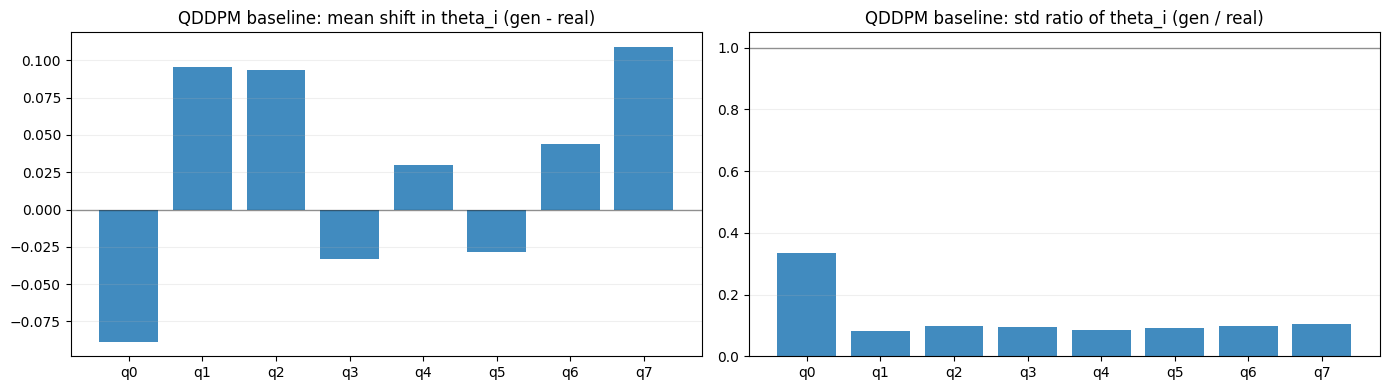

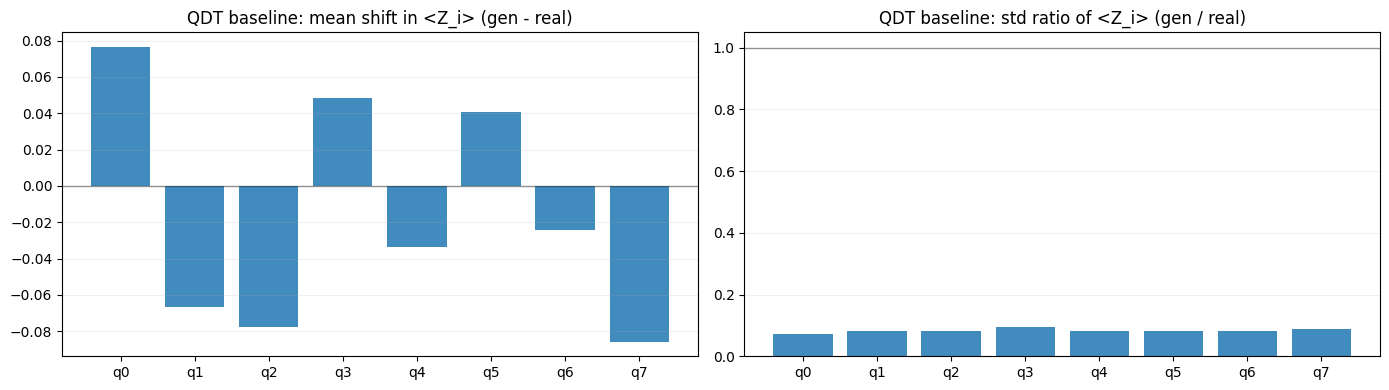

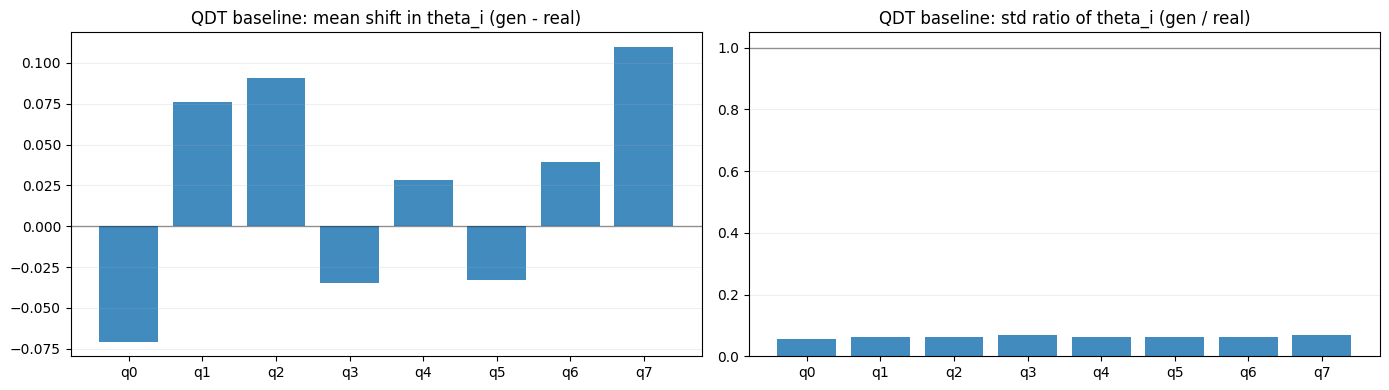


[Real] per-qubit stats
  q0:  <Z> mean=-0.078  std= 0.881   |  theta mean= 1.643  std= 1.135
  q1:  <Z> mean= 0.067  std= 0.787   |  theta mean= 1.494  std= 1.032
  q2:  <Z> mean= 0.079  std= 0.783   |  theta mean= 1.479  std= 1.021
  q3:  <Z> mean=-0.048  std= 0.652   |  theta mean= 1.605  std= 0.888
  q4:  <Z> mean= 0.035  std= 0.770   |  theta mean= 1.541  std= 1.012
  q5:  <Z> mean=-0.041  std= 0.774   |  theta mean= 1.605  std= 1.011
  q6:  <Z> mean= 0.025  std= 0.733   |  theta mean= 1.531  std= 0.957
  q7:  <Z> mean= 0.083  std= 0.701   |  theta mean= 1.464  std= 0.912

[QDDPM run] per-qubit stats
  q0:  <Z> mean= 0.025  std= 0.806   |  theta mean= 1.553  std= 0.962
  q1:  <Z> mean=-0.001  std= 0.258   |  theta mean= 1.572  std= 0.264
  q2:  <Z> mean= 0.004  std= 0.137   |  theta mean= 1.566  std= 0.139
  q3:  <Z> mean= 0.002  std= 0.103   |  theta mean= 1.569  std= 0.104
  q4:  <Z> mean=-0.003  std= 0.103   |  theta mean= 1.574  std= 0.104
  q5:  <Z> mean=-0.005  std= 0.112   

In [30]:
# 3) 定量诊断：每个 qubit 的均值偏移 & 方差比（用 Z 与 theta 两种视角）

def summarize_shift(name: str, z_gen: np.ndarray, th_gen: np.ndarray):
    dz_mean = z_gen.mean(axis=0) - z_real.mean(axis=0)
    dz_std_ratio = (z_gen.std(axis=0) + 1e-8) / (z_real.std(axis=0) + 1e-8)
    dth_mean = th_gen.mean(axis=0) - th_real.mean(axis=0)
    dth_std_ratio = (th_gen.std(axis=0) + 1e-8) / (th_real.std(axis=0) + 1e-8)

    x = np.arange(n)

    fig, axes = plt.subplots(1, 2, figsize=(14, 4))
    axes[0].bar(x, dz_mean, alpha=0.85)
    axes[0].axhline(0.0, color='k', lw=1, alpha=0.4)
    axes[0].set_title(f'{name}: mean shift in <Z_i> (gen - real)')
    axes[0].set_xticks(x)
    axes[0].set_xticklabels([f'q{i}' for i in range(n)])
    axes[0].grid(True, axis='y', alpha=0.2)

    axes[1].bar(x, dz_std_ratio, alpha=0.85)
    axes[1].axhline(1.0, color='k', lw=1, alpha=0.4)
    axes[1].set_title(f'{name}: std ratio of <Z_i> (gen / real)')
    axes[1].set_xticks(x)
    axes[1].set_xticklabels([f'q{i}' for i in range(n)])
    axes[1].grid(True, axis='y', alpha=0.2)

    plt.tight_layout()
    plt.show()

    fig, axes = plt.subplots(1, 2, figsize=(14, 4))
    axes[0].bar(x, dth_mean, alpha=0.85)
    axes[0].axhline(0.0, color='k', lw=1, alpha=0.4)
    axes[0].set_title(f'{name}: mean shift in theta_i (gen - real)')
    axes[0].set_xticks(x)
    axes[0].set_xticklabels([f'q{i}' for i in range(n)])
    axes[0].grid(True, axis='y', alpha=0.2)

    axes[1].bar(x, dth_std_ratio, alpha=0.85)
    axes[1].axhline(1.0, color='k', lw=1, alpha=0.4)
    axes[1].set_title(f'{name}: std ratio of theta_i (gen / real)')
    axes[1].set_xticks(x)
    axes[1].set_xticklabels([f'q{i}' for i in range(n)])
    axes[1].grid(True, axis='y', alpha=0.2)

    plt.tight_layout()
    plt.show()


def _maybe_summarize(label: str, z: Optional[np.ndarray], th: Optional[np.ndarray]):
    if z is None or th is None:
        return
    summarize_shift(label, z, th)


# run
_maybe_summarize(f'QDDPM run ({RUN_NAME})' if RUN_NAME else 'QDDPM run', z_qddpm_run, th_qddpm_run)
_maybe_summarize(f'QDT run ({RUN_NAME})' if RUN_NAME else 'QDT run', z_qdt_run, th_qdt_run)
if 'z_qgan_run' in globals():
    _maybe_summarize(f'QGAN run ({RUN_NAME})' if RUN_NAME else 'QGAN run', z_qgan_run, th_qgan_run)

# baseline
_maybe_summarize('QDDPM baseline', z_qddpm_base, th_qddpm_base)
_maybe_summarize('QDT baseline', z_qdt_base, th_qdt_base)
if 'z_qgan_base' in globals():
    _maybe_summarize('QGAN baseline', z_qgan_base, th_qgan_base)


# 额外：把“为什么 Z2~Z7 靠近 0”变成可量化的统计表
# 如果 real 的这些 qubit 本来就靠近 0，那么这是数据/编码本身的属性，而不是模型错误。

def _print_summary_table(tag: str, z: Optional[np.ndarray], th: Optional[np.ndarray]):
    if z is None or th is None:
        return
    print(f"\n[{tag}] per-qubit stats")
    for i in range(n):
        print(
            f"  q{i}:  <Z> mean={z[:, i].mean(): .3f}  std={z[:, i].std(): .3f}"
            f"   |  theta mean={th[:, i].mean(): .3f}  std={th[:, i].std(): .3f}"
        )


_print_summary_table('Real', z_real, th_real)
_print_summary_table('QDDPM run', z_qddpm_run, th_qddpm_run)
_print_summary_table('QDT run', z_qdt_run, th_qdt_run)
if 'z_qgan_run' in globals():
    _print_summary_table('QGAN run', z_qgan_run, th_qgan_run)

_print_summary_table('QDDPM baseline', z_qddpm_base, th_qddpm_base)
_print_summary_table('QDT baseline', z_qdt_base, th_qdt_base)
if 'z_qgan_base' in globals():
    _print_summary_table('QGAN baseline', z_qgan_base, th_qgan_base)


/tmp/ipykernel_1408969/4291764163.py:37: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


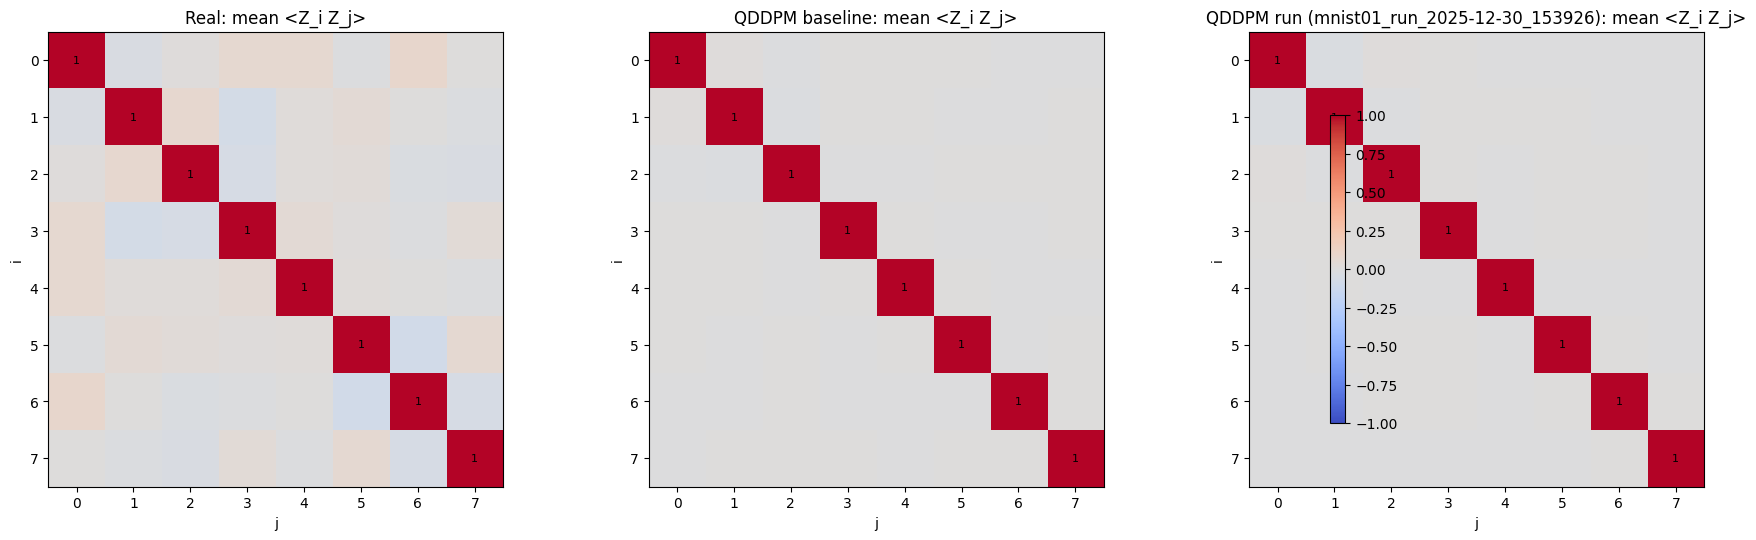

In [26]:
# 4) <Z_i Z_j> 均值热力图（Real vs QDDPM/QDT/QGAN；baseline + run）

def zz_mean_matrix(zz: np.ndarray, n: int) -> np.ndarray:
    m = np.eye(n, dtype=np.float32)
    mean = zz.mean(axis=0)
    for k, (i, j) in enumerate(PAIR_IJ):
        m[i, j] = mean[k]
        m[j, i] = mean[k]
    return m


def _collect_zz_mats():
    mats = [("Real", zz_mean_matrix(zz_real, n))]

    if zz_qddpm_base is not None:
        mats.append(("QDDPM baseline", zz_mean_matrix(zz_qddpm_base, n)))
    if zz_qddpm_run is not None:
        label = f"QDDPM run ({RUN_NAME})" if RUN_NAME else "QDDPM run"
        mats.append((label, zz_mean_matrix(zz_qddpm_run, n)))

    if zz_qdt_base is not None:
        mats.append(("QDT baseline", zz_mean_matrix(zz_qdt_base, n)))
    if zz_qdt_run is not None:
        label = f"QDT run ({RUN_NAME})" if RUN_NAME else "QDT run"
        mats.append((label, zz_mean_matrix(zz_qdt_run, n)))

    # QGAN (optional)
    if 'zz_qgan_base' in globals() and zz_qgan_base is not None:
        mats.append(("QGAN baseline", zz_mean_matrix(zz_qgan_base, n)))
    if 'zz_qgan_run' in globals() and zz_qgan_run is not None:
        label = f"QGAN run ({RUN_NAME})" if RUN_NAME else "QGAN run"
        mats.append((label, zz_mean_matrix(zz_qgan_run, n)))

    return mats

items = _collect_zz_mats()
if len(items) == 0:
    raise ValueError('No ZZ matrices to plot')

vmax = float(np.max([np.max(np.abs(m)) for _, m in items]))
vmax = max(vmax, 1e-6)

fig, axes = plt.subplots(1, len(items), figsize=(6 * len(items), 5))
if len(items) == 1:
    axes = [axes]

for ax, (title, mat) in zip(axes, items):
    im = ax.imshow(mat, vmin=-vmax, vmax=vmax, cmap='coolwarm')
    ax.set_xticks(range(n))
    ax.set_yticks(range(n))
    ax.set_xlabel('j')
    ax.set_ylabel('i')
    ax.set_title(title)
    for i in range(n):
        ax.text(i, i, '1', ha='center', va='center', fontsize=8, color='black')

fig.colorbar(im, ax=axes, shrink=0.8)
plt.tight_layout()
plt.show()


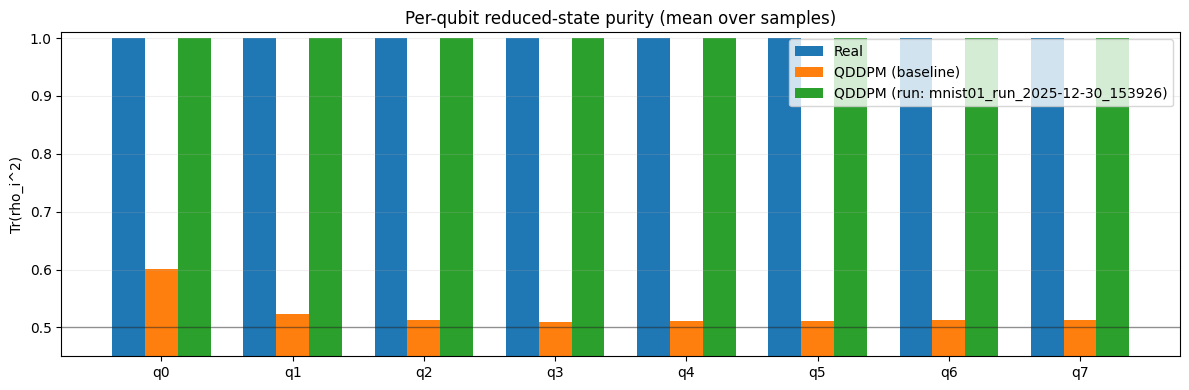

Average purity over samples & qubits:
  real      : 1.0000000143772922
  qddpm_base : 0.5243195666262181
  qddpm_run  : 1.0000001532607712


In [27]:
# 5) 单比特纯度：每个 qubit 的均值（Real vs QDDPM/QDT/QGAN；baseline + run）

x = np.arange(n)
w = 0.14

bars = [("Real", pur_real.mean(axis=0))]

if pur_qddpm_base is not None:
    bars.append(("QDDPM baseline", pur_qddpm_base.mean(axis=0)))
if pur_qddpm_run is not None:
    bars.append((f"QDDPM run ({RUN_NAME})" if RUN_NAME else "QDDPM run", pur_qddpm_run.mean(axis=0)))

if pur_qdt_base is not None:
    bars.append(("QDT baseline", pur_qdt_base.mean(axis=0)))
if pur_qdt_run is not None:
    bars.append((f"QDT run ({RUN_NAME})" if RUN_NAME else "QDT run", pur_qdt_run.mean(axis=0)))

# QGAN (optional)
if 'pur_qgan_base' in globals() and pur_qgan_base is not None:
    bars.append(("QGAN baseline", pur_qgan_base.mean(axis=0)))
if 'pur_qgan_run' in globals() and pur_qgan_run is not None:
    bars.append((f"QGAN run ({RUN_NAME})" if RUN_NAME else "QGAN run", pur_qgan_run.mean(axis=0)))

plt.figure(figsize=(12, 4))
for k, (name, vals) in enumerate(bars):
    offset = (k - (len(bars) - 1) / 2) * w
    plt.bar(x + offset, vals, width=w, label=name)

plt.axhline(0.5, color='k', lw=1, alpha=0.4)
plt.ylim(0.45, 1.01)
plt.xticks(x, [f'q{i}' for i in range(n)])
plt.title('Per-qubit reduced-state purity (mean over samples)')
plt.ylabel('Tr(rho_i^2)')
plt.grid(True, axis='y', alpha=0.2)
plt.legend(fontsize=8)
plt.tight_layout()
plt.show()

print('Average purity over samples & qubits:')
print('  real       :', float(pur_real.mean()))
if pur_qddpm_base is not None: print('  qddpm_base :', float(pur_qddpm_base.mean()))
if pur_qddpm_run is not None:  print('  qddpm_run  :', float(pur_qddpm_run.mean()))
if pur_qdt_base is not None:   print('  qdt_base   :', float(pur_qdt_base.mean()))
if pur_qdt_run is not None:    print('  qdt_run    :', float(pur_qdt_run.mean()))
if 'pur_qgan_base' in globals() and pur_qgan_base is not None: print('  qgan_base  :', float(pur_qgan_base.mean()))
if 'pur_qgan_run' in globals() and pur_qgan_run is not None:   print('  qgan_run   :', float(pur_qgan_run.mean()))


# 如何解读“纯度在 0.5 左右”

`Tr(ρ_i^2) ≈ 0.5` 表示第 i 个 qubit 的单体约化态接近最大混合。这个现象可以出现在两种情况：

1. 真实数据本身强纠缠：那 real 的单比特纯度也会近似 0.5。
2. 生成模型偏离了 real 的结构：如果 real 纯度明显高于 0.5（更接近 product），但生成却近似 0.5，那就是明显的“纠缠结构不匹配”。

所以判断“好不好”需要对照 real，而不是单看生成的纯度数值。